# Distortion Classification

In [10]:
import torch
import torchaudio
import os

### Define transformation

In [11]:
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050*3

mfcc = torchaudio.transforms.MFCC(
    sample_rate = SAMPLE_RATE, 
    n_mfcc = 64,
    melkwargs = {
        "n_fft": 1024,
        "hop_length": 1024,
        "n_mels": 64,
        "center": False})

#### Functions for training

In [12]:
from src.gtfxdataset import GtFxDataset
from src.util import plot_spectrogram
from src.extrector import train
from src.extrector import model
from torch import nn

AUDIO_DIR = "_assets/DATASET/GT-FX-C53/"
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "train.csv")
EVU_ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "evaluation.csv")
EFFECT_MAP = ["distortion", "chorus", "tremolo", "delay", "reverb"]

def load_train_data(effect):
    
    fxData = GtFxDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device,
                        effect=EFFECT_MAP[effect])
    return fxData

def load_evaluation_data(effect):

    evuData = GtFxDataset(EVU_ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device,
                        effect=EFFECT_MAP[effect])

    BATCH_SIZE = round(len(evuData) / 1500)
    val_dataloader = train.create_data_loader(evuData, BATCH_SIZE)
    return val_dataloader

def split_data(data):

    BATCH_SIZE = round(len(data) / 1500)

    split_ratio = [0.9, 0.1]
    train_set, test_set = torch.utils.data.random_split(data, lengths=split_ratio)

    train_dataloader = train.create_data_loader(train_set, BATCH_SIZE)
    test_dataloader = train.create_data_loader(test_set, BATCH_SIZE)

    return train_dataloader, test_dataloader   

#### Add Tensorboard to record data

In [13]:
from torch.utils.tensorboard import SummaryWriter

EXPERIMENT_NAME = "c53_parameter"
LOG_DIR = "_log/" + EXPERIMENT_NAME
EVU_DIR = "_log/Evaluation/"

if not os.path.exists('%s' % LOG_DIR):
    os.makedirs('%s' % LOG_DIR)

if not os.path.exists('%s' % EVU_DIR):
    os.makedirs('%s' % EVU_DIR)

log_writer = SummaryWriter(LOG_DIR)


#### Model training

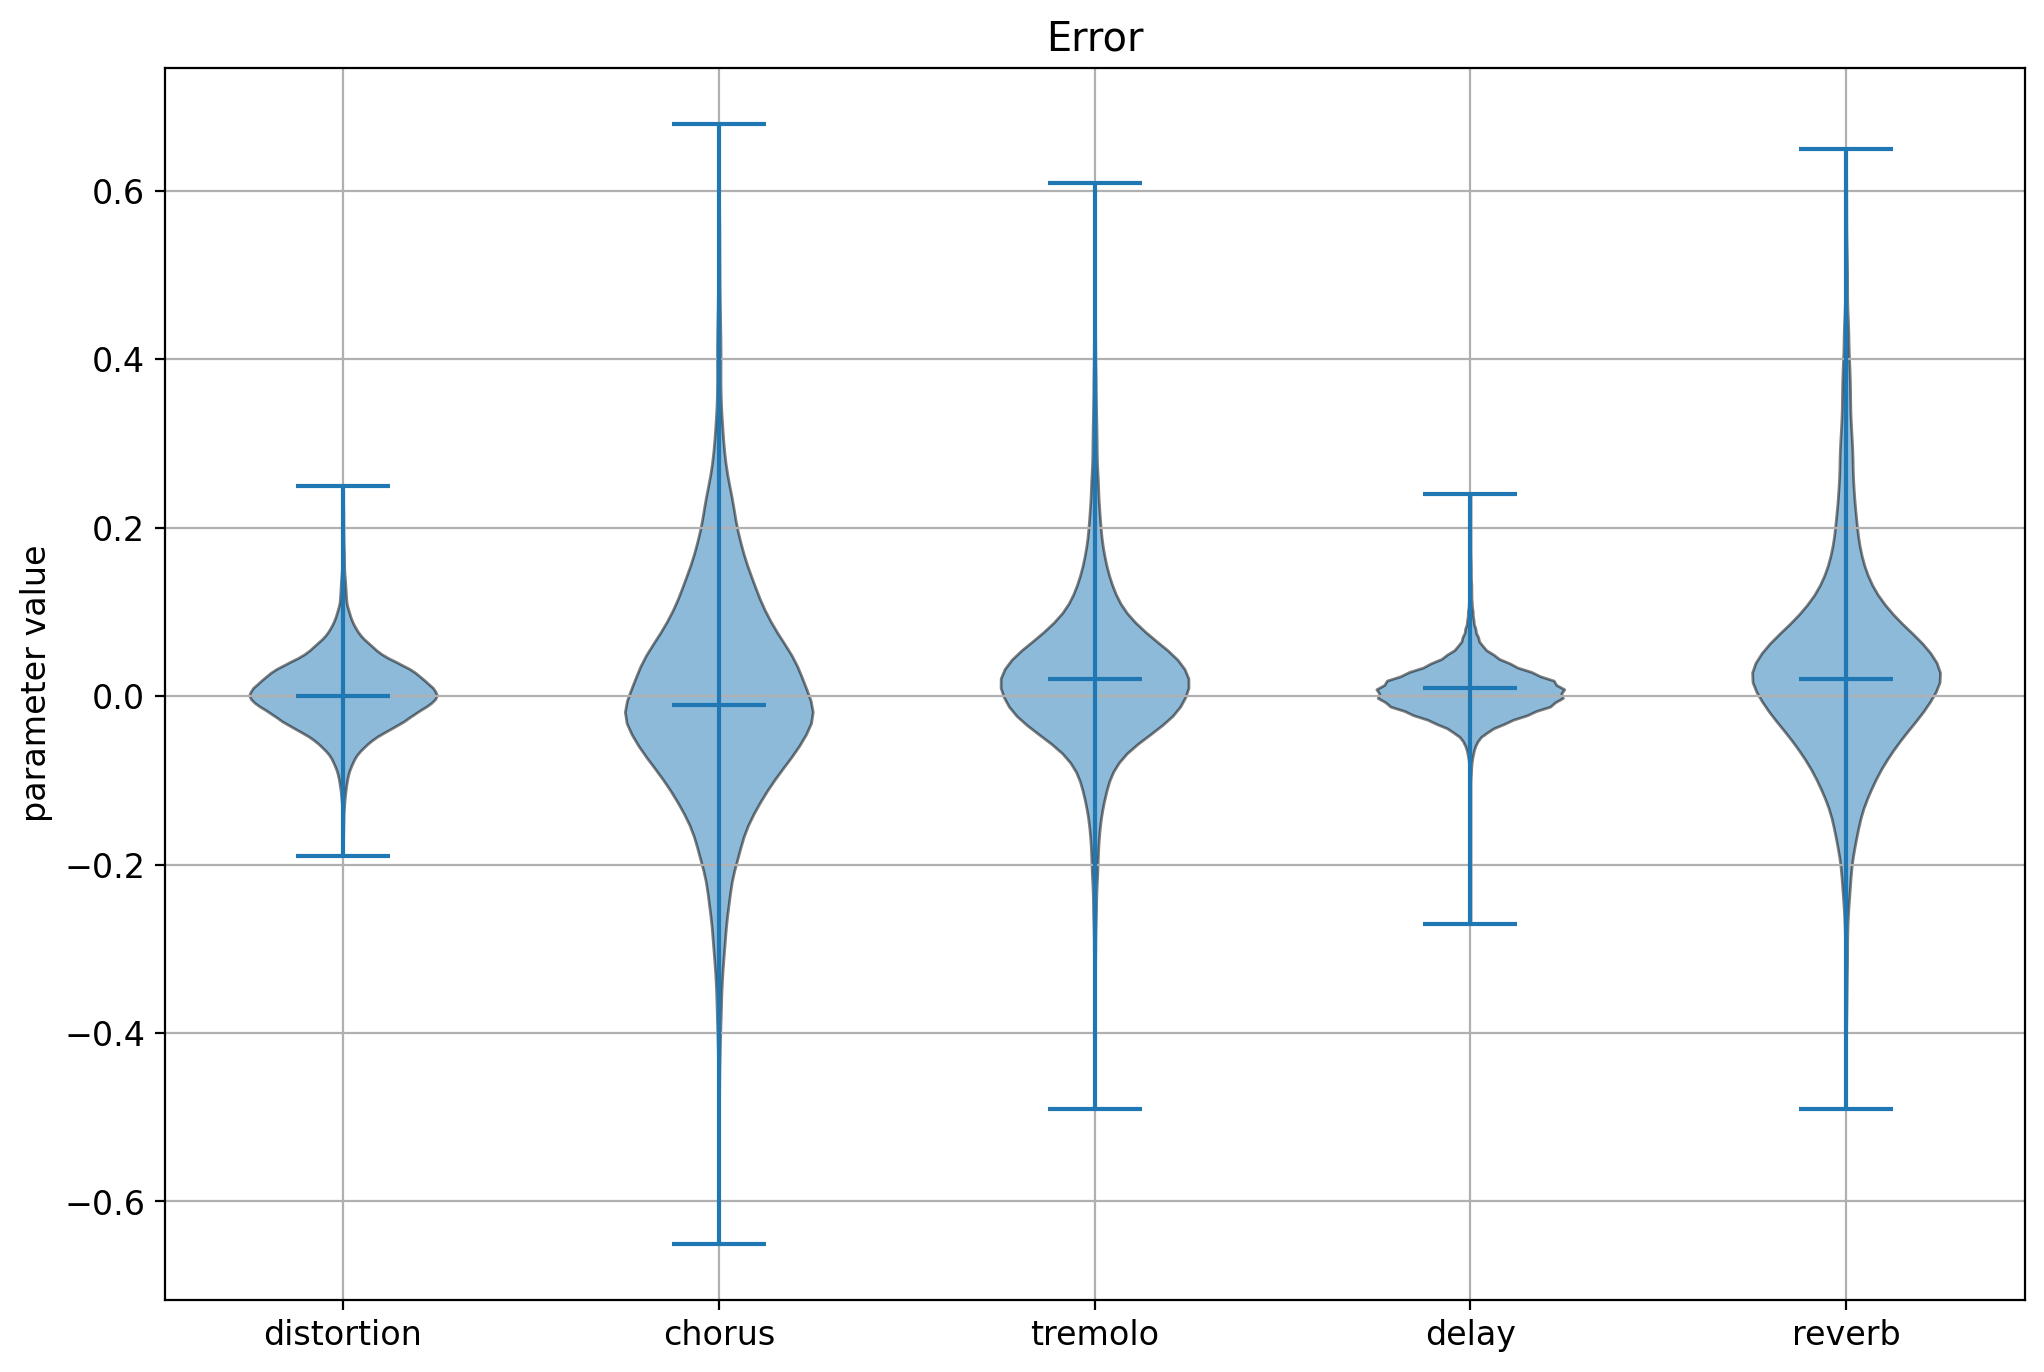

In [15]:
from src.util import plot_violin
import numpy as np

WEIGHTS_DIR = "_weights/"
LEARNING_RATE = 0.001
EPOCHS = 20

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

error = [[], [], [], [], []]

for fx in range(5):

    WEIGHTS_PATH = os.path.join(WEIGHTS_DIR, EXPERIMENT_NAME + "_" + str(fx))

    if not os.path.exists('%s' % WEIGHTS_DIR):
        os.makedirs('%s' % WEIGHTS_DIR)

    fxData = load_train_data(fx)
    # fxData, _ = torch.utils.data.random_split(fxData, lengths=[0.01, 0.99])
    
    train_dataloader, test_dataloader = split_data(fxData)
    val_dataloader = load_evaluation_data(fx)
    
    # construct model and assign it to device
    cnn = model.Extractor().to(device)
    
    if fx == 0:
        signal, _, _, _, _ = fxData[0]
        print(f"There are {len(fxData)} samples in the dataset.")
        print(f"Shape of signal: {signal.shape}")

        print("input feature:")
        log_writer.add_figure("Input Feature", plot_spectrogram(signal[0], title="MFCC"))
        log_writer.add_graph(cnn, signal.unsqueeze_(0))

    # initialise loss funtion + optimiser
    loss_fn = nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

    # train model
    train.train(cnn,
                train_dataloader,
                test_dataloader,
                loss_fn,
                optimiser,
                device,
                log_writer,
                EPOCHS,
                WEIGHTS_PATH,
                effect=fx)

    _, _, log = train.test(cnn, val_dataloader, device, effect=fx)
    for _, data in enumerate(log):
        error[fx].append(data[3])

    arr = np.array(error[fx])
    np.save(EVU_DIR + EXPERIMENT_NAME + "_" + str(fx) + "_evaluation.npy", arr)

log_writer.add_figure("Error Box", 
                      plot_violin(error, title="Error", labels=EFFECT_MAP, ylabel="parameter value", outlier=True))

log_writer.close()